In [2]:
from dask import dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from functools import reduce
import seaborn as sns
from sklearn import preprocessing
from pandas import DataFrame
from pandas import concat
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from random import randrange

from random import seed
from random import random
from matplotlib import pyplot
import pandas
from pandas.plotting import autocorrelation_plot
from keras import Model
from keras.layers import GRU, Dense, Input, Dropout, LSTM, concatenate
%matplotlib inline

from numpy.random import seed as np_seed
from tensorflow import set_random_seed
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback

from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

from datetime import datetime
from sklearn.preprocessing import OneHotEncoder

SEED = 42

seed(SEED)
np_seed(SEED)
set_random_seed(SEED)


path = '../data/'




In [3]:
df_sds011 = dd.read_csv(path + 'processed*sds011*').compute()
df_dht22 = dd.read_csv(path + 'processed*dht22*').compute()

df_sds011['timestamp'] = pd.to_datetime(df_sds011['timestamp'], format='%Y-%m-%dT%H:%M:%S')
df_dht22['timestamp'] = pd.to_datetime(df_dht22['timestamp'], format='%Y-%m-%dT%H:%M:%S')

df_sds011 = df_sds011.set_index(['location', 'timestamp'])
df_dht22 = df_dht22.set_index(['location', 'timestamp'])

df_sds011 = df_sds011.sort_index()
df_dht22 = df_dht22.sort_index()

df_sds011 = df_sds011[['P1', 'P2']]
df_dht22 = df_dht22[['temperature', 'humidity']]

df_cars = pd.read_csv('../cars.csv', sep=';', header=None, names=['timestamp', 'n_cars'])
df_cars['timestamp'] = pd.to_datetime(df_cars['timestamp'], format='%Y-%m-%dT%H:%M:%S')
df_cars = df_cars.set_index(df_cars.timestamp, drop=True)
df_cars = df_cars.drop(columns=['timestamp'])
df_cars = df_cars.sort_index()

In [4]:
print(df_sds011.shape)
print(df_dht22.shape)
print(df_cars.shape)
print(df_sds011.isnull().sum())
print(df_dht22.isnull().sum())
print(df_cars.isnull().sum())

(784111, 2)
(788307, 2)
(5770, 1)
P1    0
P2    0
dtype: int64
temperature    0
humidity       0
dtype: int64
n_cars    0
dtype: int64


In [5]:
df_sds011.describe()

,P1,P2
count,784111.000000,784111.000000
mean,27.726486,16.304882
std,32.476811,18.071175
min,0.000000,0.000000
25%,7.130000,3.870000
50%,14.770000,8.700000
75%,37.230000,22.070000
max,1999.900000,564.800000


In [7]:
df_dht22.describe()

,temperature,humidity
count,788307.000000,788307.000000
mean,12.399143,80.187920
std,9.049283,23.148502
min,-10.400000,5.200000
25%,5.500000,62.900000
50%,10.400000,91.200000
75%,18.700000,99.900000
max,57.800000,99.900000


In [8]:
import seaborn as sns
sns.set()
sns.set_context('talk')
sns.set_style('darkgrid')

3123
Q3 99.9 Q1 99.9 fence_low 99.9 fence_high 99.9
3642
Q3 99.9 Q1 53.3 fence_low -16.60000000000001 fence_high 169.8
6367
Q3 99.5 Q1 44.9 fence_low -37.00000000000001 fence_high 181.4
8732
Q3 84.3 Q1 62.5 fence_low 29.800000000000004 fence_high 117.0
10574
Q3 98.2 Q1 82.2 fence_low 58.2 fence_high 122.2


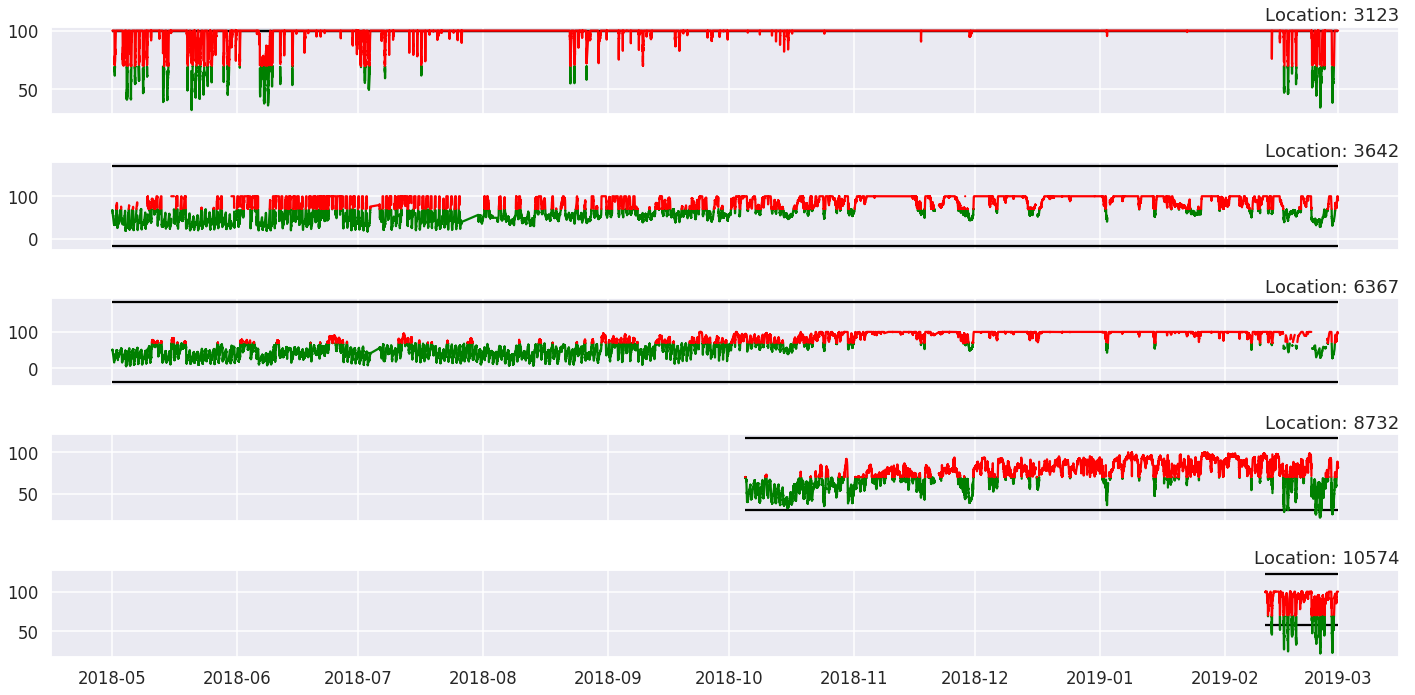

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 10), sharex=True, sharey=False)

for idx, (loc, loc_df) in enumerate(df_dht22[df_dht22.index.get_level_values(1) > '2018-05-01'].groupby('location')):
    print(loc)

    upper = 70#50
    lower = 0#20

    s = loc_df['humidity']
    t = loc_df.index.get_level_values(1)
    
    supper = np.ma.masked_where(s < upper, s)
    slower = np.ma.masked_where(s > lower, s)
    smiddle = np.ma.masked_where(np.logical_or(s < lower, s > upper), s)

    q3 = s.quantile(.75)
    q1 = s.quantile(.25)

    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr # mild outlier
    fence_high = q3+1.5*iqr # mild outlier

    print('Q3', q3, 'Q1', q1, 'fence_low', fence_low, 'fence_high', fence_high)

    axes[idx].plot(t, smiddle, 'green', t, slower, 'red', t, supper, 'red')
    axes[idx].set_title('Location: %s' % str(loc), loc='right')
    axes[idx].hlines(y=fence_high, xmin=t.min(), xmax=t.max(),color='black', linestyle='-')
    axes[idx].hlines(y=fence_low, xmin=t.min(), xmax=t.max(),color='black', linestyle='-')

    plt.tight_layout()


location
3123     AxesSubplot(0.125,0.125;0.775x0.755)
3642     AxesSubplot(0.125,0.125;0.775x0.755)
6367     AxesSubplot(0.125,0.125;0.775x0.755)
8732     AxesSubplot(0.125,0.125;0.775x0.755)
10574    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

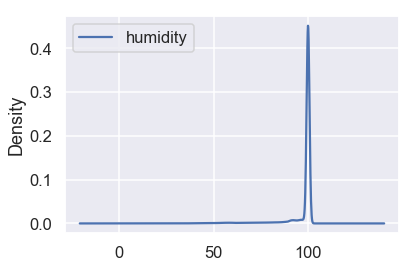

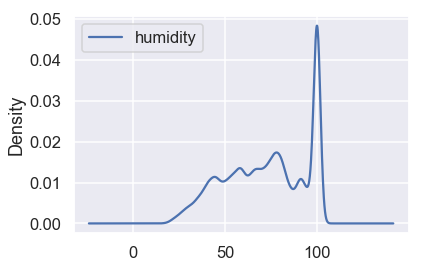

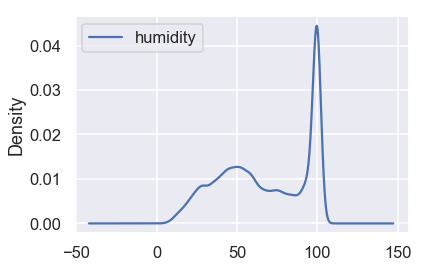

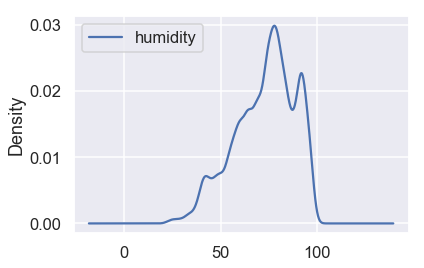

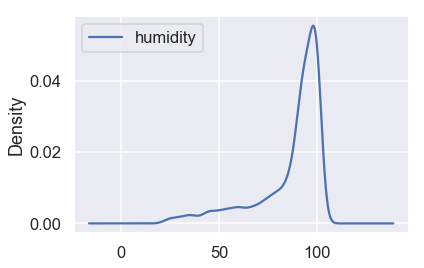

In [9]:
df_dht22.groupby(level=0)[['humidity']].plot(kind='kde')

# Drop unnecessary  data 

In [10]:
df_sds011 = df_sds011.drop([3123, 10574], level=0)
df_dht22 = df_dht22.drop([3123, 10574], level=0)
print(df_sds011.isnull().sum())
print(df_dht22.isnull().sum())

P1    0
P2    0
dtype: int64
temperature    0
humidity       0
dtype: int64


# Outliers

In [11]:
def remove_outlier(df):
    res = df[np.abs(df - df.mean()) <= (3*df.std())]
    #print(res.groupby(level=0).count())
    return res.dropna()


print(df_sds011.shape)
print(df_dht22.shape)

df_sds011 = remove_outlier(df_sds011)
df_dht22 = remove_outlier(df_dht22)

print(df_sds011.shape)
print(df_dht22.shape)

print('NaNs')
print(df_sds011.isnull().sum())
print(df_dht22.isnull().sum())

(499557, 2)
(500805, 2)
(487342, 2)
(496244, 2)
NaNs
P1    0
P2    0
dtype: int64
temperature    0
humidity       0
dtype: int64


In [12]:
df_sds011.describe()

,P1,P2
count,487342.000000,487342.000000
mean,22.232030,15.823582
std,23.393535,16.911751
min,0.000000,0.000000
25%,6.000000,3.800000
50%,11.600000,8.330000
75%,31.430000,21.670000
max,114.600000,76.500000


In [13]:
df_dht22.describe()

,temperature,humidity
count,496244.000000,496244.000000
mean,13.223225,71.149308
std,8.930904,22.812142
min,-10.400000,5.200000
25%,6.200000,53.100000
50%,11.500000,73.400000
75%,20.000000,93.000000
max,41.800000,99.900000


In [23]:
## Grenzwert ermittlung von PM10 und PM2.5 für Tagesmittelwerte und Jahresmittelwerte 
temp1 = df_sds011.groupby(level=1).mean().sort_index()
temp2 = df_dht22.groupby(level=1).mean().sort_index()


day_sds = temp1.groupby(pd.Grouper(freq='1D', level=0)).mean().dropna()
day_dht = temp2[temp2.humidity <= 70.0].groupby(pd.Grouper(freq='1D', level=0)).mean().dropna()

year_sds = temp1.groupby(pd.Grouper(freq='1Y', level=0)).mean().dropna()
year_dht = temp2[temp2.humidity <= 70.0].groupby(pd.Grouper(freq='1Y', level=0)).mean().dropna()

year = pd.merge(year_sds, year_dht, left_index=True, right_index=True, how='inner')

day = pd.merge(day_sds, day_dht, left_index=True, right_index=True, how='inner')

print('Tage über dem Grenzwert bzw. Richtwert')
print('P10: ', day[day['P1'] > 50].shape[0])
print('P2.5: ', day[day['P2'] > 25].shape[0])


Tage über dem Grenzwert bzw. Richtwert
P10:  22
P2.5:  69


# Resample and Merge

In [12]:
print(df_sds011.shape)
print(df_dht22.shape)

df_sds011 = df_sds011.groupby(level=1).mean().sort_index()
df_dht22 = df_dht22.groupby(level=1).mean().sort_index()

df_sds011 = df_sds011.groupby(pd.Grouper(freq='60min', level=0)).mean().dropna()
df_dht22 = df_dht22[df_dht22.humidity <= 70].groupby(pd.Grouper(freq='60min', level=0)).mean().dropna()

print(df_sds011.shape)
print(df_dht22.shape)


(487342, 2)
(496244, 2)
(11008, 2)
(6789, 2)


In [13]:
data = pd.merge(df_sds011, df_dht22, left_index=True, right_index=True, how='inner')
print(data.isnull().sum())
print(data.shape)
data.head()

P1             0
P2             0
temperature    0
humidity       0
dtype: int64
(6785, 4)


,P1,P2,temperature,humidity
timestamp,,,,
2017-11-20 09:00:00,11.602083,4.926667,8.204762,67.704762
2017-11-20 10:00:00,11.801600,4.736400,9.316000,63.924000
2017-11-20 11:00:00,11.670000,4.793750,10.037500,60.404167
2017-11-20 12:00:00,10.525000,4.752917,9.708333,61.770833
2017-11-20 13:00:00,9.345600,4.531600,9.416000,64.852000


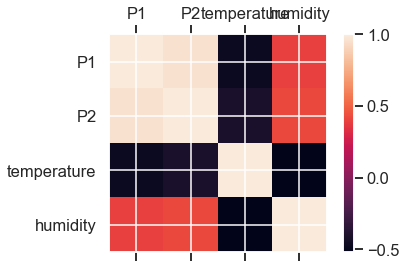

In [31]:

alpha = list(data.columns.values)

fig = plt.figure()

ax = fig.add_subplot(111)
cax = ax.matshow(data.corr(), interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()



# Add add car features

In [14]:
df_cars = df_cars.groupby(pd.Grouper(freq='60min', level=0)).sum()
car_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
df_cars['n_cars'] = car_scaler.fit_transform(df_cars['n_cars'].values.reshape(-1,1).astype('float'))
df_cars.head()

,n_cars
timestamp,
2019-02-06 17:00:00,-0.990476
2019-02-06 18:00:00,-0.961905
2019-02-06 19:00:00,-0.961905
2019-02-06 20:00:00,-0.961905
2019-02-06 21:00:00,-0.952381


# Add date features

In [15]:


day_of_week = lambda x: x.weekday()
week_number = lambda x: x.strftime('%V')
hour = lambda x: x.hour

cat_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')

day_of_week = data.index.map(day_of_week).astype('int')
week_number = data.index.map(week_number).astype('int')
hour = data.index.map(hour).astype('int')

day_of_week = cat_scaler.fit_transform(onehot_encoder.fit_transform(day_of_week.values.reshape(-1,1)))
week_number = cat_scaler.fit_transform(onehot_encoder.fit_transform(week_number.values.reshape(-1,1)))
hour = cat_scaler.fit_transform(onehot_encoder.fit_transform(hour.values.reshape(-1,1)))
date_features = np.concatenate([day_of_week, week_number, hour], axis=1)

df_date = pd.DataFrame(date_features, index=data.index)
df_date.head()

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-11-20 09:00:00,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 10:00:00,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 11:00:00,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 12:00:00,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 13:00:00,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# Time Series

In [16]:

#from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [17]:
data = data[['temperature', 'P1']]
data = series_to_supervised(data, n_in=1, n_out=1, dropnan=True)
data.head()

,var1(t-1),var2(t-1),var1(t),var2(t)
timestamp,,,,
2017-11-20 10:00:00,8.204762,11.602083,9.316000,11.801600
2017-11-20 11:00:00,9.316000,11.801600,10.037500,11.670000
2017-11-20 12:00:00,10.037500,11.670000,9.708333,10.525000
2017-11-20 13:00:00,9.708333,10.525000,9.416000,9.345600
2017-11-20 14:00:00,9.416000,9.345600,8.913043,7.041818


In [20]:
data['diff2-1'] = data['var2(t)'] - data['var2(t-1)']
data['diff1-1'] = data['var1(t)'] - data['var1(t-1)']
data.head()

,var1(t-1),var2(t-1),var1(t),var2(t),diff2-1,diff1-1
timestamp,,,,,,
2017-11-20 10:00:00,8.204762,11.602083,9.316000,11.801600,0.199517,1.111238
2017-11-20 11:00:00,9.316000,11.801600,10.037500,11.670000,-0.131600,0.721500
2017-11-20 12:00:00,10.037500,11.670000,9.708333,10.525000,-1.145000,-0.329167
2017-11-20 13:00:00,9.708333,10.525000,9.416000,9.345600,-1.179400,-0.292333
2017-11-20 14:00:00,9.416000,9.345600,8.913043,7.041818,-2.303782,-0.502957


In [21]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit_transform(data)
data = DataFrame(scaler, index=data.index, columns=data.columns)
data.head()

,var1(t-1),var2(t-1),var1(t),var2(t),diff2-1,diff1-1
timestamp,,,,,,
2017-11-20 10:00:00,-0.291133,-0.812681,-0.248362,-0.809061,0.080389,-0.078720
2017-11-20 11:00:00,-0.248362,-0.809061,-0.220592,-0.811448,0.074263,-0.105097
2017-11-20 12:00:00,-0.220592,-0.811448,-0.233261,-0.832222,0.055513,-0.176205
2017-11-20 13:00:00,-0.233261,-0.832222,-0.244513,-0.853620,0.054876,-0.173712
2017-11-20 14:00:00,-0.244513,-0.853620,-0.263871,-0.895418,0.034073,-0.187967


# Combine Sensor Features with Date Features / Car Data

In [22]:
data = pd.merge(data, df_date, left_index=True, right_index=True, how='inner')
data.head()

,var1(t-1),var2(t-1),var1(t),var2(t),diff2-1,diff1-1,0,1,2,3,...,73,74,75,76,77,78,79,80,81,82
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-11-20 10:00:00,-0.291133,-0.812681,-0.248362,-0.809061,0.080389,-0.078720,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 11:00:00,-0.248362,-0.809061,-0.220592,-0.811448,0.074263,-0.105097,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 12:00:00,-0.220592,-0.811448,-0.233261,-0.832222,0.055513,-0.176205,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 13:00:00,-0.233261,-0.832222,-0.244513,-0.853620,0.054876,-0.173712,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2017-11-20 14:00:00,-0.244513,-0.853620,-0.263871,-0.895418,0.034073,-0.187967,1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [23]:
car_data = pd.merge(df_cars, data, left_index=True, right_index=True, how='inner')
print(car_data.shape)
car_data.head()


(258, 90)


,n_cars,var1(t-1),var2(t-1),var1(t),var2(t),diff2-1,diff1-1,0,1,2,...,73,74,75,76,77,78,79,80,81,82
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-02-07 00:00:00,-0.933333,-0.334616,-0.599767,-0.331831,-0.513971,0.164192,-0.149029,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-02-07 01:00:00,-0.933333,-0.331831,-0.513971,-0.343862,-0.546483,0.043543,-0.175083,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-02-07 02:00:00,-0.961905,-0.343862,-0.546483,-0.353059,-0.570301,0.052408,-0.170099,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-02-07 03:00:00,-0.942857,-0.353059,-0.570301,-0.365545,-0.591207,0.055378,-0.175882,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-02-07 04:00:00,-0.942857,-0.365545,-0.591207,-0.377724,-0.620337,0.046992,-0.175343,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# Model training

In [24]:
def create_model(batch_size, dim, stateful=True):
    if batch_size:
        inp = Input(batch_shape=(batch_size,1, dim))
    else:
        inp = Input(shape=(1,dim,))
    x = GRU(50, stateful=stateful, return_sequences=False)(inp)
    x = Dropout(0.2)(x)
    x = Dense(50, activation='sigmoid')(x)
    x = Dropout(0.2)(x)
    clf = Dense(1)(x)

    model = Model(inp, clf)
    feature_extractor = Model(inp, x)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model, feature_extractor

def create_pre_trained_model(old_model):
    feature_extractor = Model(old_model.inputs, old_model.layers[-2].output)  

    for l in feature_extractor.layers:
        l.trainable = False

    inp_car = Input(shape=(1,))
    x = Dense(5, name='car-features')(inp_car)
    x = Dropout(0.2)(x)
    x = concatenate([feature_extractor.output, x])
    x = Dense(1, activation='sigmoid')(x)
    new_model = Model(inputs=[feature_extractor.input, inp_car], outputs=x)
    new_model.compile(loss='mean_squared_error', optimizer='adam')
    return new_model

def create_data(train, test):
    """
    Train and Test parameters are pandas DataFrames.
    """
    y_train = train[['var2(t)']].values
    X_train = train.drop(columns=['var2(t)']).values

    X_test = test.drop(columns=['var2(t)']).values
    y_test = test[['var2(t)']].values

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    return X_train, X_test, y_train, y_test

def predict_baseline(train, test):
    """
    Train and Test parameters are pandas DataFrames.
    """
    ### Persistence Baseline
    baseline = mean_squared_error(test['var2(t-1)'].values, test['var2(t)'].values)
    print('Persistence Baseline %.6f' % baseline)
    return baseline, test[['var2(t-1)', 'var2(t)']]


def train_normal(X_train, X_test, y_train, y_test):
    model, _ = create_model(None, X_train.shape[-1], stateful=False)
    model.fit(X_train, y_train, epochs=50000, shuffle=True, batch_size=len(X_train), validation_data=(X_test, y_test), callbacks=[TQDMNotebookCallback(leave_inner=False, leave_outer=True, show_inner=False)], verbose=0)
    return model, model

def train_timeseries(X_train, X_test, y_train, y_test):
    train_model, _= create_model(len(X_train), X_train.shape[-1])
    test_model, _ = create_model(len(X_test), X_train.shape[-1])

    pbar = tqdm(range(10000), leave=True)

    for i in pbar:
        train_model.fit(X_train, y_train, epochs=1, shuffle=False, batch_size=len(X_train), verbose=0)
        train_model.reset_states()

        test_model.set_weights(train_model.get_weights())
        r = test_model.evaluate(X_test, y_test, batch_size=len(X_test), verbose=0)
        pbar.set_description("Test: %.6f" % r)
    return train_model, test_model


def train_predict_pretrained(X_train, X_car_train, X_test, X_car_test, y_train, y_test, model):
    hist = model.fit([X_train, X_car_train], y_train, epochs=5000, shuffle=True, batch_size=(len(X_train)), validation_data=([X_test, X_car_test], y_test), callbacks=[TQDMNotebookCallback(leave_inner=False, leave_outer=True, show_inner=False)], verbose=0)
    
    pred = model.predict([X_test, X_car_test], batch_size=len(X_test))
    mse = mean_squared_error(pred.reshape(pred.shape[0]),  y_test)
    
    df = pd.DataFrame(index=test.index)
    df['pred'] = pred.reshape(pred.shape[0])
    df['true'] = y_test
    
    return mse, df, model, hist

def predict(X_train, X_test, y_train, y_test, train_fn):

    result = {}

    train_model, test_model = train_fn(X_train, X_test, y_train, y_test)

    pred = test_model.predict(X_test, batch_size=len(X_test))
    mse = mean_squared_error(pred.reshape(pred.shape[0]),  y_test)
        
    df = pd.DataFrame(index=test.index)
    df['pred'] = pred.reshape(pred.shape[0])
    df['true'] = y_test
    
    
    return mse, df, train_model, test_model


def plot_eval(df, test):
    test[['var2(t-1)', 'var2(t)']].plot(figsize=(25,5))
    df.plot(figsize=(25,5))

kfold = KFold(3, shuffle=False, random_state=SEED)

results_ts = []
results_norm = []
for train, test in kfold.split(data):
    
    train, test = data.iloc[train], data.iloc[test]
    baseline, baseline_df = predict_baseline(train, test)
    
    X_train, X_test, y_train, y_test = create_data(train, test)
    
    #TODO plot history
    
    mse, df, train_model, test_model = predict(X_train, X_test, y_train, y_test, train_timeseries)
    results_ts.append((baseline, mse, baseline_df, df, train_model, test_model, test))
    
    mse, df, train_model, test_model = predict(X_train, X_test, y_train, y_test, train_normal)
    results_norm.append((baseline, mse, baseline_df, df, train_model, test_model, test))

    

def print_res(results):
    print('Baseline mse %.5f (%.5f STD)' % (np.mean(results[:,0]), np.std(results[:,0])))
    print('Model mse %.5f (%.5f STD)' % (np.mean(results[:,1]), np.std(results[:,1])))
    
    
results_ts = np.asarray(results_ts)
results_norm = np.asarray(results_norm)
 
print_res(results_ts)
print_res(results_norm)

models = results_norm[:, -3]

results_pt_norm = []
for train, test in kfold.split(car_data):
    
    train, test = car_data.iloc[train], car_data.iloc[test]

    X_car_train = train['n_cars'].values
    X_car_test = test['n_cars'].values

    train = train.drop(columns=['n_cars'])
    test = test.drop(columns=['n_cars'])

    X_train, X_test, y_train, y_test = create_data(train, test)
    
    for model in models:


        pretrained_model = create_pre_trained_model(model)

        mse, df, pretrained_model, hist = train_predict_pretrained(X_train, X_car_train, X_test, X_car_test, y_train, y_test, pretrained_model)
        print(mse)

        results_pt_norm.append((mse, df, pretrained_model, hist))
    
    
results_pt_norm = np.asarray(results_pt_norm)

Persistence Baseline 0.006393



Persistence Baseline 0.001165



Persistence Baseline 0.005926



Baseline mse 0.00449 (0.00236 STD)
Model mse 0.03202 (0.02066 STD)
Baseline mse 0.00449 (0.00236 STD)
Model mse 0.00220 (0.00053 STD)



0.24908447613647972



0.2482476632954353



0.24808143271153402



0.08931651812016503



0.08931426460124947



0.08928196106483921



0.11553031998082207



0.11553539907656053



0.11553193298253182


In [26]:
print('Transfer Model MSE')
print(np.mean(results_pt_norm[:, 0]))
print(np.std(results_pt_norm[:, 0]))

print('Time Series Model MSE')
print_res(results_ts)
print('Normal Model MSE')
print_res(results_norm)

Transfer Model MSE
0.15110266310773524
0.06967806949031527
Time Series Model MSE
Baseline mse 0.00449 (0.00236 STD)
Model mse 0.03202 (0.02066 STD)
Normal Model MSE
Baseline mse 0.00449 (0.00236 STD)
Model mse 0.00220 (0.00053 STD)


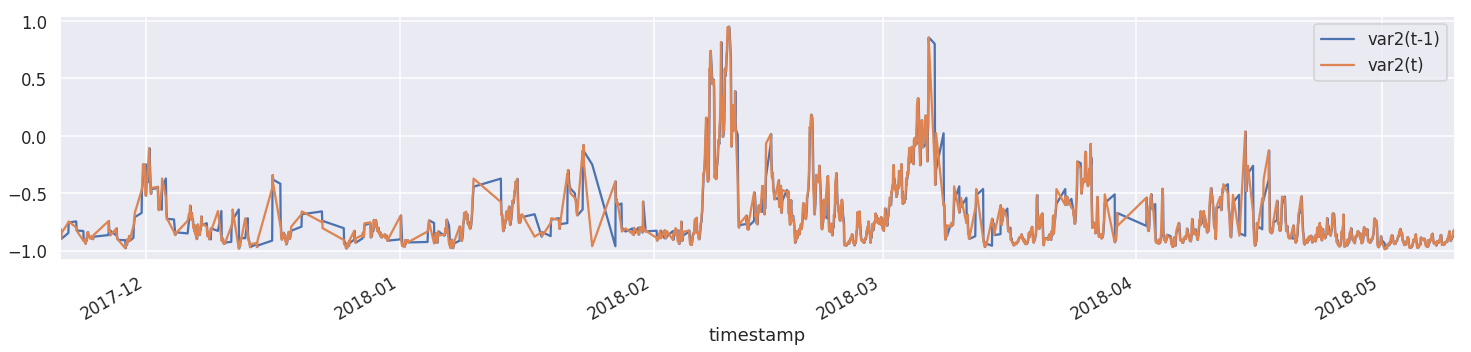

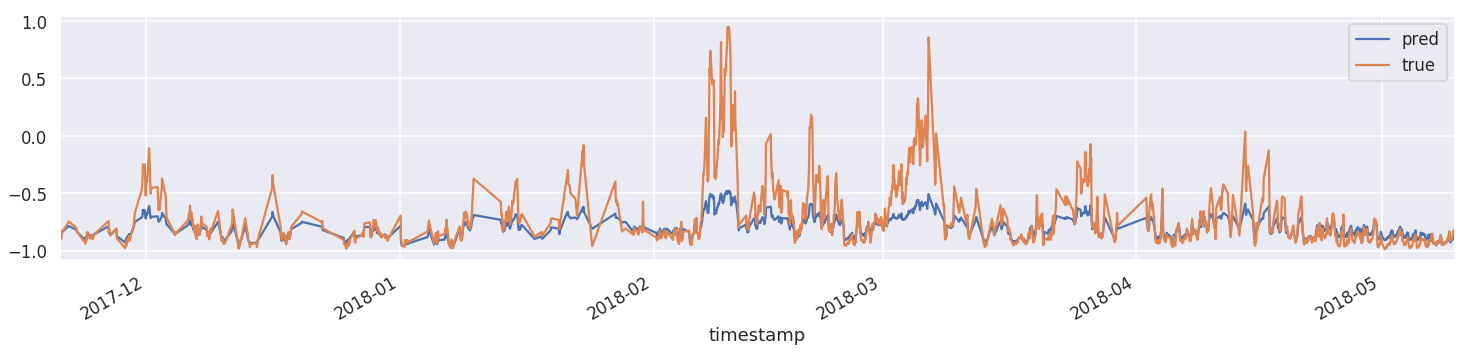

In [27]:
plot_eval(results_ts[0][3], results_ts[0][-1])

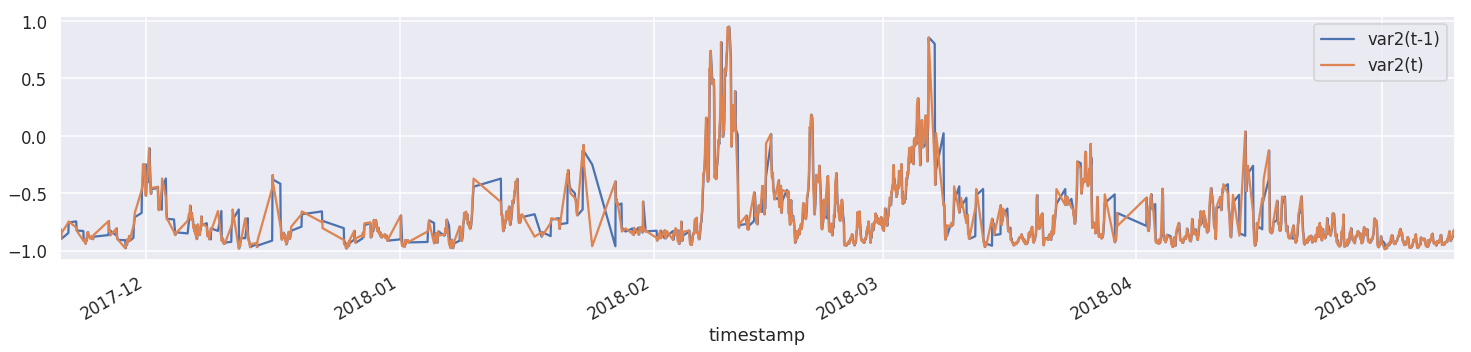

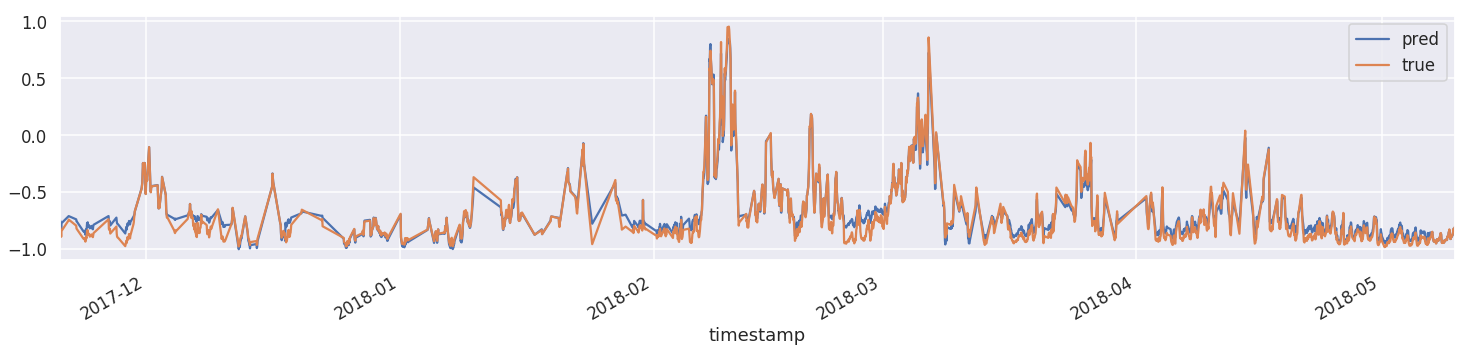

In [29]:
plot_eval(results_norm[0][3], results_norm[0][-1])

# Check for Random Walk, Stationarity ...

In [49]:
# statistical test
result = adfuller(data['var2(t)'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.666837
p-value: 0.000001
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


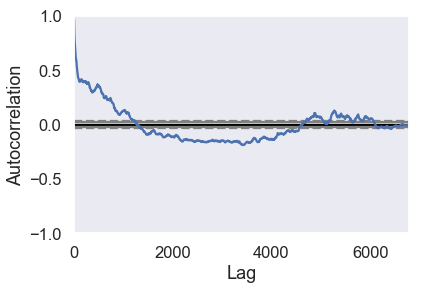

In [55]:
#P1
plot = autocorrelation_plot(data[['var2(t)']])

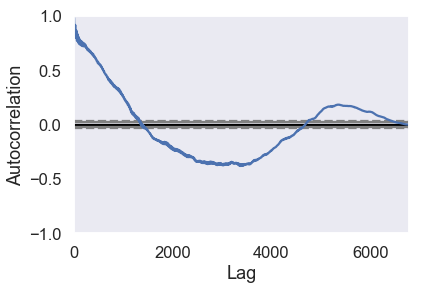

In [56]:
#Temp
plot = autocorrelation_plot(data[['var1(t)']])

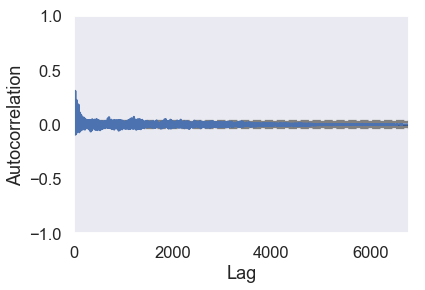

In [53]:
plot = autocorrelation_plot(data[['diff1-1']])